The purpose of this note book is to test the impact of different ways of modeling xylem damage on Speries profit max model.

In [1]:
import sys
sys.path.append('../')

from src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials, CumulativeWeibullDistribution
from src.HydraulicConductanceModels.capped_conductance_model import CappedHydraulicConductanceModel
from src.HydraulicConductanceModels.D_S_Mackay_damage_model import D_S_Mackay_damage_model_from_conductance_loss

from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.rubisco_CO2_and_O_model import RubiscoRates
from src.electron_transport_rate_model import ElectronTransportRateModel
from src.michaelis_menten_response_function import michaelis_menten_constant

# -- Temperature dependency models --
from src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelRubiscoLimitedLeuning as PhotosynthesisModelRubiscoLimited
from src.PhotosynthesisModels.Leuning_Model import PhotosynthesisModelElectronTransportLimitedLeuning as PhotosynthesisModelElectronTransportLimited

# -- Profit Models --
from src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from src.ProfitModels.profit_max_model import ProfitMaxModel

# -- Unit conversions --
from src.conversions import (magnitude_conversion,
                             mole_carbon_to_grams,
                             per_day_to_per_second,
                             per_second_to_per_half_hour,
                             convert_transpiration_rate_to_latent_energy,
                             short_wave_to_photosynthetically_active_radiation,
                             light_energy_in_joules_to_micro_moles_of_light,
                             degrees_kelvin_to_centigrade,
                             degrees_centigrade_to_kelvin,
                             convert_stomatal_conductance_of_carbon_to_water)

import numpy as np
from matplotlib import pyplot as plt

# Capped conductance model

The first model of damaged xylem conductance envolves capping the conductance of an existing vunrebility curve.

$$
k_{cap}(\psi) = MIN(k(\psi),k_{cap})
$$

The code below creates and plots a capped version of a Cumulative Weibul distribution conductance model.

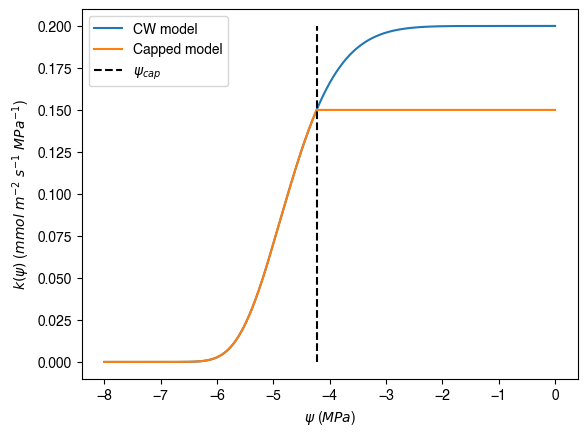

In [2]:
# Conductance model
P50 = -4.739999999999999 # MPa
P88 = -5.476604474129552 # MPa
k_max = 0.2 # mmol m-2 s-1 MPa-1
k_cap = 0.15 # mmol m-2 s-1 MPa-1

# Create the base cumulative weibul conductance model.
CW_conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                       P50,
                                                                                                       P88,
                                                                                                       0.5,
                                                                                                       0.88)

# Create the capped conductance model
Capped_conductance_model = CappedHydraulicConductanceModel(CW_conductance_model, k_cap)

# Get the water potential at which the conductance changes to being capped
psi_cap_switch = Capped_conductance_model.water_potential_at_cap_switch()

# Calculate and plot the two vulnerability curves.
psi_array = np.linspace(0,-8,1000)

CW_conductance_array = CW_conductance_model.conductance(psi_array)
Capped_conductance_array = Capped_conductance_model.conductance(psi_array)

# Plot the two vulnerability curves
plt.plot(psi_array, CW_conductance_array, label = "CW model")
plt.plot(psi_array, Capped_conductance_array, label = "Capped model")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,k_max], c = 'black', linestyle = "--", label = "$\psi_{cap}$")

plt.legend()
plt.xlabel("$\psi$ ($MPa$)")
plt.ylabel("$k(\psi)$ ($mmol \\ m^{-2} \\ s^{-1} \\ MPa^{-1}$)")
plt.show()

We can see how this impacts the transpiration rate as a function of leaf water potential.

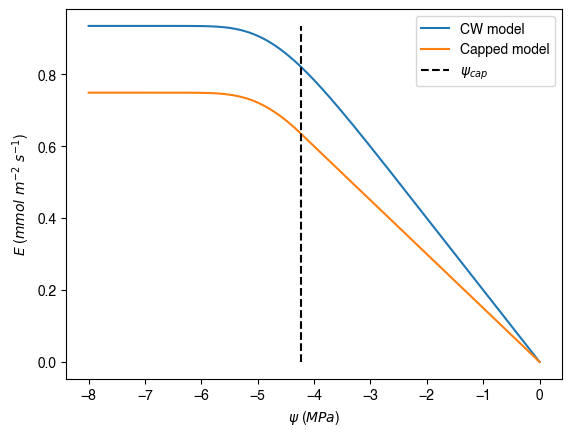

In [3]:
CW_transpiration_array = np.zeros(len(psi_array))
Capped_transpiration_array = np.zeros(len(psi_array))

# Calculate the different transpiration rates.
for i in range(1, len(psi_array)):
    CW_transpiration_array[i] = CW_conductance_model.transpiration(psi_array[i], psi_array[0], 1000)
    Capped_transpiration_array[i] = Capped_conductance_model.transpiration(psi_array[i], psi_array[0], 1000)

# Plot the transpiration as a function of leaf water potential
plt.plot(psi_array, CW_transpiration_array, label = "CW model")
plt.plot(psi_array, Capped_transpiration_array, label = "Capped model")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,CW_transpiration_array[-1]], c = 'black', linestyle = "--", label = "$\psi_{cap}$")

plt.legend()
plt.xlabel("$\psi$ ($MPa$)")
plt.ylabel("$E$ ($mmol \\ m^{-2} \\ s^{-1}$)")
plt.show()

# Hydraulic cost

Having constructed the capped conductance model how does this impact the hydraulic cost?

Here we make use of the Sperry model of hydraulic cost, defined as;

$$
HC(\psi_{leaf}) = \frac{k_{i,max} - k(\psi_{leaf})}{k_{i,max} - k_{crit}} 
$$

where, $k_{i,max}$ is the maximuk achivable conductance under the current conditions and is equal to the conductance at the root water potential, and $k_{crit}$ is the critical conductance below which the tree dies.

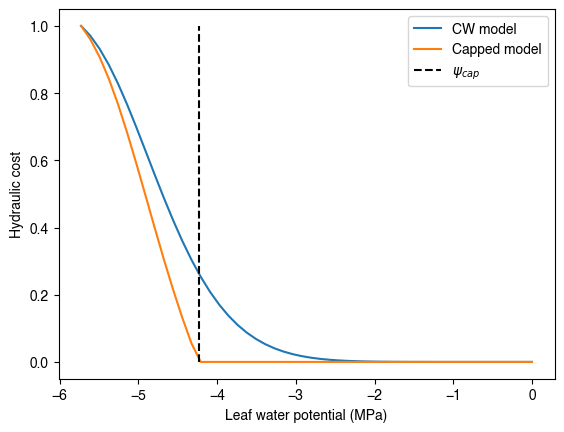

In [4]:
# -- Setup the hydraulic cost models --
critical_water_potential = CW_conductance_model.water_potential_from_conductivity_loss_fraction(0.95) # MPa

hydraulic_cost_model_CW = HydraulicCostModel(CW_conductance_model, critical_water_potential)
hydraulic_cost_model_cap = HydraulicCostModel(Capped_conductance_model, critical_water_potential)

# Calculate the cost as a function of leaf water potential
psi_soil = -0. # MPa
psi_leaf_array = np.linspace(psi_soil, critical_water_potential) # MPa

hydraulic_cost_array_CW = hydraulic_cost_model_CW.hydraulic_cost_as_a_function_of_leaf_water_potential(psi_leaf_array, psi_soil)
hydraulic_cost_array_cap = hydraulic_cost_model_cap.hydraulic_cost_as_a_function_of_leaf_water_potential(psi_leaf_array, psi_soil)

# Plot the hydraulic costs
plt.plot(psi_leaf_array, hydraulic_cost_array_CW, label = "CW model")
plt.plot(psi_leaf_array, hydraulic_cost_array_cap, label = "Capped model")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,1], c = 'black', linestyle = "--", label = "$\psi_{cap}$")

plt.legend()
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Hydraulic cost")
plt.show()


# Profit, Sperry

To test the impact of using the capped model on profit as a function of leaf water potential we first need to build the two profit models with underlying photosynthesis modeling.

In [5]:
# -- Rubisco limited photo synthesis model setup --
maximum_carboxylation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 30.,
                                                        activation_energy = 60000.,
                                                        deactivation_energy = 200000.,
                                                        entropy_term = 650.)

maximum_oxegentation_rate_model = PeakedArrheniusModel(rate_at_25_centigrade = 60.,
                                                       activation_energy = 3000.,
                                                       deactivation_energy = 200000.,
                                                       entropy_term = 650.)

michaelis_menten_constant_CO2_model = ArrheniusModel(rate_at_25_centigrade=404.9,
                                                     activation_energy=79430.0)

michaelis_menten_constant_O_model = ArrheniusModel(rate_at_25_centigrade=278.4,
                                                   activation_energy=36380.0)

rubisco_rates_model = RubiscoRates(maximum_carboxylation_rate_model,
                                   maximum_oxegentation_rate_model,
                                   michaelis_menten_constant_CO2_model,
                                   michaelis_menten_constant_O_model)

# -- CO2 compensation point --
CO2_compensation_point_model = ArrheniusModel(rate_at_25_centigrade = 42.75,
                                            activation_energy = 37830.0)

# -- mitochondrial respiration rate model --
mitochondrial_respiration_rate_model = Q10TemperatureDependenceModel(value_at_25C = 0.6,
                                                                     Q10_parameter = 2.)

# -- Rubisco limited model --
photosynthesis_model_rubisco_limited = PhotosynthesisModelRubiscoLimited(rubisco_rates_model = rubisco_rates_model,
                                                                         CO2_compensation_point_model = CO2_compensation_point_model,
                                                                         mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)


In [6]:
# -- Electron transport limmited photosynthesis model setup --
maximum_electron_transport_rate_model = LowTemperatureAdjustedModel(PeakedArrheniusModel(rate_at_25_centigrade = 60., 
                                                                                         activation_energy = 30000., 
                                                                                         deactivation_energy = 200000., 
                                                                                         entropy_term = 650.),
                                                                   lower_bound_C = 0.,
                                                                   upper_bound_C = 10.)

electron_transport_rate_model = ElectronTransportRateModel(curvature_parameter = 0.85,
                                                           maximum_electron_transport_rate_model = maximum_electron_transport_rate_model)

photosynthesis_model_electron_transport_limited = PhotosynthesisModelElectronTransportLimited(electron_transport_rate_model = electron_transport_rate_model,
                                                                                              CO2_compensation_point_model = CO2_compensation_point_model,
                                                                                              mitochondrial_respiration_rate_model = mitochondrial_respiration_rate_model)


In [7]:
# Leaf air coupling model
leaf_air_coupling_model = LeafAirCouplingModel()

# Photosynthesis model
photosynthesis_model = PhotosynthesisModel(photosynthesis_model_rubisco_limited,
                                           photosynthesis_model_electron_transport_limited)

# Carbon gain model
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

In [8]:
# -- Create the two Profit models --
profit_optimisation_model_CW = ProfitMaxModel(hydraulic_cost_model_CW, leaf_air_coupling_model, CO2_gain_model)
profit_optimisation_model_cap = ProfitMaxModel(hydraulic_cost_model_cap, leaf_air_coupling_model, CO2_gain_model)

Having built the two profit models we need to setup the environmental conditions around the tree.

In [9]:
# Soil properties
soil_water_potential = -0.5 # MPa

# Temperature
air_temperature = degrees_centigrade_to_kelvin(25.)

# Transpiration drivers
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

# Photosynthesis drivers
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosyntheticaly_acitve_radiation = 500. #(umol m-2 s-1)
intercellular_oxygen = 210.0 #(umol mol-1)


print("soil water potential: ", soil_water_potential, " MPa")
print("air temperature: ", air_temperature, " K")
print("air vapour pressure deficit: ", air_vapour_pressure_deficit, " kPa")
print("air pressure: ", air_pressure, " kPa")
print("atmospheric CO2 concentration: ", atmospheric_CO2_concentration, " umol mol-1")
print("inter cellular oxygen concentration: ", intercellular_oxygen, " umol mol-1")
print("photosyntheticaly active radiation: ", photosyntheticaly_acitve_radiation, " umol m-2 s-1")

soil water potential:  -0.5  MPa
air temperature:  298.15  K
air vapour pressure deficit:  1  kPa
air pressure:  101.9  kPa
atmospheric CO2 concentration:  419.0  umol mol-1
inter cellular oxygen concentration:  210.0  umol mol-1
photosyntheticaly active radiation:  500.0  umol m-2 s-1


Now let us plot the two different models

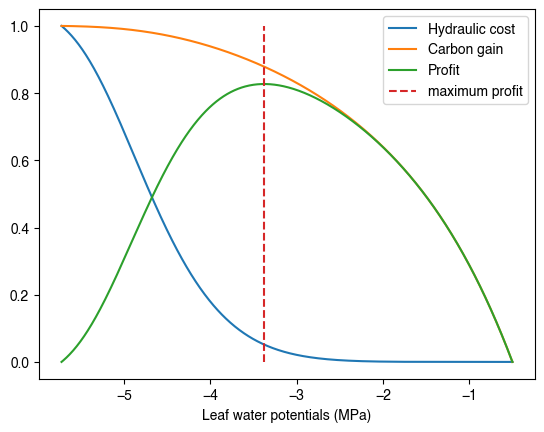

In [10]:
profit_values_CW, carbon_gain_CW, hydraulic_costs_CW, __, __, __, __, water_potentials_CW = \
    profit_optimisation_model_CW.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                              air_temperature,
                                                                              air_vapour_pressure_deficit,
                                                                              air_pressure,
                                                                              atmospheric_CO2_concentration,
                                                                              intercellular_oxygen,
                                                                              photosyntheticaly_acitve_radiation,
                                                                              number_of_sample_points = 1000)

maximum_profit_id_CW = np.nanargmax(profit_values_CW)
optimal_leaf_water_potential_CW = water_potentials_CW[maximum_profit_id_CW]

plt.plot(water_potentials_CW, hydraulic_costs_CW, label = "Hydraulic cost")
plt.plot(water_potentials_CW, carbon_gain_CW, label = "Carbon gain")
plt.plot(water_potentials_CW, profit_values_CW, label = "Profit")
plt.plot([optimal_leaf_water_potential_CW, optimal_leaf_water_potential_CW], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

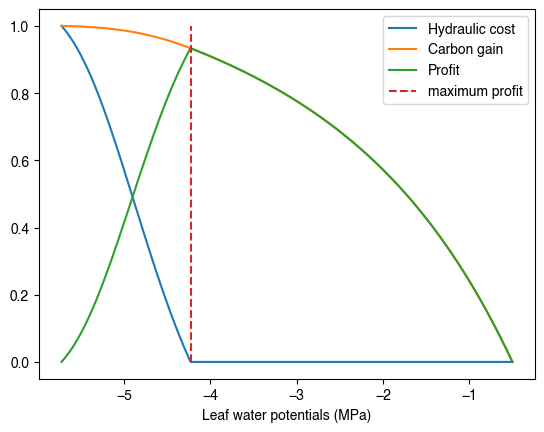

In [11]:
profit_values_cap, carbon_gain_cap, hydraulic_costs_cap, __, __, __, __, water_potentials_cap = \
    profit_optimisation_model_cap.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                               air_temperature,
                                                                               air_vapour_pressure_deficit,
                                                                               air_pressure,
                                                                               atmospheric_CO2_concentration,
                                                                               intercellular_oxygen,
                                                                               photosyntheticaly_acitve_radiation,
                                                                               number_of_sample_points = 1000)

maximum_profit_id_cap = np.nanargmax(profit_values_cap)
optimal_leaf_water_potential_cap = water_potentials_cap[maximum_profit_id_cap]

plt.plot(water_potentials_cap, hydraulic_costs_cap, label = "Hydraulic cost")
plt.plot(water_potentials_cap, carbon_gain_cap, label = "Carbon gain")
plt.plot(water_potentials_cap, profit_values_cap, label = "Profit")
plt.plot([optimal_leaf_water_potential_cap, optimal_leaf_water_potential_cap], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

# D.S.Mackay model

Alternativly we can use the damaged conductance model described in [D.S.Mackay et. al. 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015WR017244).

The process of calculating the newly damaged conductance model, described by [D.S.Mackay et. al. 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015WR017244), starts by first applying a cap to the existing model at the current conductance, as coded above. A new cumulative weibull distribution is then created by;

1. Setting the new $k_{max}'$ equal to the capped conductance.

2. Setting the new sensetivity parameter $b'$ equal to the water potential at which the current model is equal to the capped conductance times e to the power of minus one. The new value $b'$ is hence given by,

$$
b' = b(1-\ln(\frac{k_{cap}}{k_{max}}))^{1/c}
$$

3. The new value of the shape parrameter $c'$ is then found by fitting the cumulative Weibull function to the capped vulnerability curve. A least squares method is used to fit $c$ by minimising the value of,

$$
\frac{(\sum_{i=1}^N P_i k_i')^2}{(\sum_{i=1}^N P_i)^2(\sum_{i=1}^N k_i')^2}
$$

where P is the fractional conductance loss of the capped conductance model,

$$
P_i = 1-\frac{k_{cap} (\psi_i)}{k_{cav}}
$$

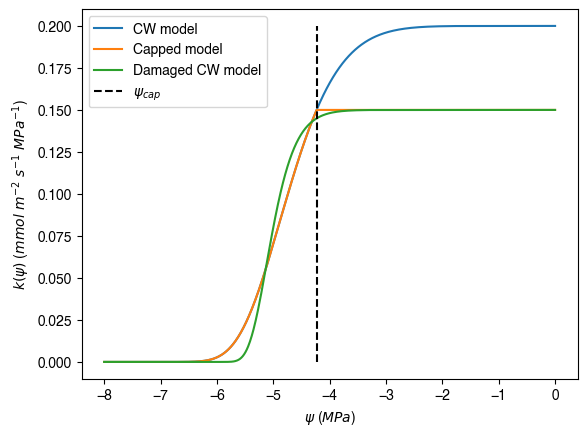

In [12]:
# Create new dammaged cumulative Weibull distribution
damaged_CW_conductance_model = D_S_Mackay_damage_model_from_conductance_loss(k_max,
                                                                             P50,
                                                                             P88,
                                                                             0.5,
                                                                             0.88)

# Apply damage to the model
psi_cap = damaged_CW_conductance_model.water_potential_from_conductance(k_cap)
damaged_CW_conductance_model._damage_xylem(psi_cap, 0., 0.)

# calculate conductance to plot
damaged_CW_conductance_array = damaged_CW_conductance_model.conductance(psi_array)

# Plot the two vulnerability curves
plt.plot(psi_array, CW_conductance_array, label = "CW model")
plt.plot(psi_array, Capped_conductance_array, label = "Capped model")
plt.plot(psi_array, damaged_CW_conductance_array, label = "Damaged CW model")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,k_max], c = 'black', linestyle = "--", label = "$\psi_{cap}$")

plt.legend()
plt.xlabel("$\psi$ ($MPa$)")
plt.ylabel("$k(\psi)$ ($mmol \\ m^{-2} \\ s^{-1} \\ MPa^{-1}$)")
plt.show()

We can see how this impacts the transpiration rate.

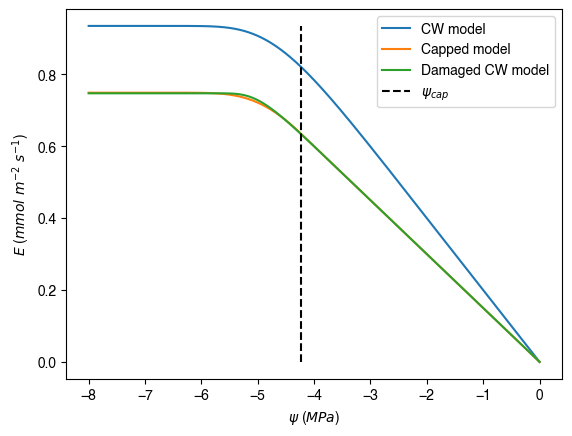

In [13]:
damaged_CW_transpiration_array = np.zeros(len(psi_array))

# Calculate the different transpiration rates.
for i in range(1, len(psi_array)):
    damaged_CW_transpiration_array[i] = damaged_CW_conductance_model.transpiration(psi_array[i], psi_array[0], 1000)

# Plot the transpiration as a function of leaf water potential
plt.plot(psi_array, CW_transpiration_array, label = "CW model")
plt.plot(psi_array, Capped_transpiration_array, label = "Capped model")
plt.plot(psi_array, damaged_CW_transpiration_array, label = "Damaged CW model")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,CW_transpiration_array[-1]], c = 'black', linestyle = "--", label = "$\psi_{cap}$")

plt.legend()
plt.xlabel("$\psi$ ($MPa$)")
plt.ylabel("$E$ ($mmol \\ m^{-2} \\ s^{-1}$)")
plt.show()

How does this affect the hydraulic cost compared to the previous two models?

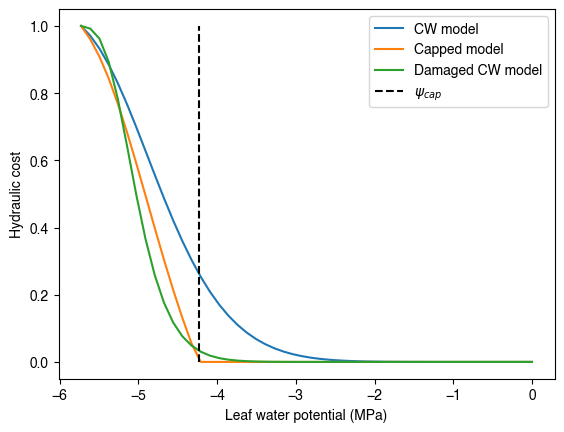

In [14]:
# -- Setup the hydraulic cost models --
critical_water_potential = CW_conductance_model.water_potential_from_conductivity_loss_fraction(0.95) # MPa

hydraulic_cost_model_damaged_CW = HydraulicCostModel(damaged_CW_conductance_model, critical_water_potential)

# Calculate the cost as a function of leaf water potential
psi_soil = -0. # MPa
psi_leaf_array = np.linspace(psi_soil, critical_water_potential) # MPa

hydraulic_cost_array_damaged_CW = hydraulic_cost_model_damaged_CW.hydraulic_cost_as_a_function_of_leaf_water_potential(psi_leaf_array, psi_soil)

# Plot the hydraulic costs
plt.plot(psi_leaf_array, hydraulic_cost_array_CW, label = "CW model")
plt.plot(psi_leaf_array, hydraulic_cost_array_cap, label = "Capped model")
plt.plot(psi_leaf_array, hydraulic_cost_array_damaged_CW, label = "Damaged CW model")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,1], c = 'black', linestyle = "--", label = "$\psi_{cap}$")

plt.legend()
plt.xlabel("Leaf water potential (MPa)")
plt.ylabel("Hydraulic cost")
plt.show()


Finaly how does this impact the profit model?

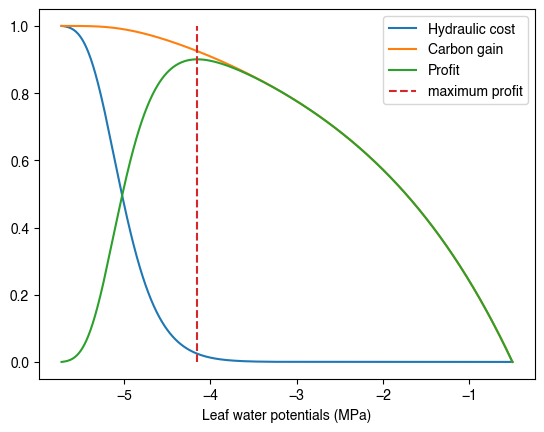

In [15]:
# create the profit model
profit_optimisation_model_damaged_CW = ProfitMaxModel(hydraulic_cost_model_damaged_CW, leaf_air_coupling_model, CO2_gain_model)

profit_values_damaged_CW, carbon_gain_damaged_CW, hydraulic_costs_damaged_CW, __, __, __, __, water_potentials_damaged_CW = \
    profit_optimisation_model_damaged_CW.profit_as_a_function_of_leaf_water_potential(soil_water_potential,
                                                                                      air_temperature,
                                                                                      air_vapour_pressure_deficit,
                                                                                      air_pressure,
                                                                                      atmospheric_CO2_concentration,
                                                                                      intercellular_oxygen,
                                                                                      photosyntheticaly_acitve_radiation,
                                                                                      number_of_sample_points = 1000)

maximum_profit_id_damaged_CW = np.nanargmax(profit_values_damaged_CW)
optimal_leaf_water_potential_damaged_CW = water_potentials_damaged_CW[maximum_profit_id_damaged_CW]

plt.plot(water_potentials_damaged_CW, hydraulic_costs_damaged_CW, label = "Hydraulic cost")
plt.plot(water_potentials_damaged_CW, carbon_gain_damaged_CW, label = "Carbon gain")
plt.plot(water_potentials_damaged_CW, profit_values_damaged_CW, label = "Profit")
plt.plot([optimal_leaf_water_potential_damaged_CW, optimal_leaf_water_potential_damaged_CW], [0,1], linestyle='--', label = "maximum profit")
plt.legend()
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("")
plt.show()

For clarity lets directly compare the different profit curves and their peaks

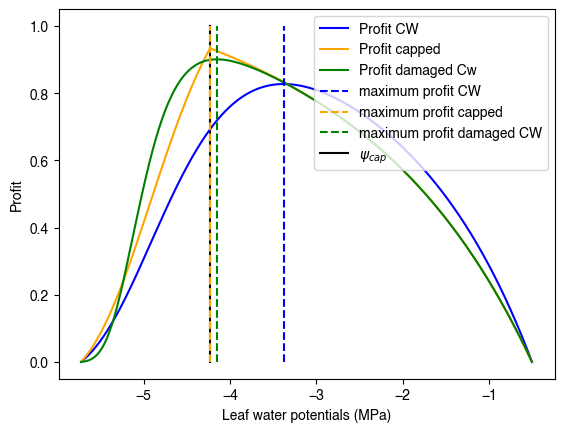

In [16]:
# Profit curves
plt.plot(water_potentials_CW, profit_values_CW, c = 'blue', label = "Profit CW")
plt.plot(water_potentials_cap, profit_values_cap, c = 'orange', label = "Profit capped")
plt.plot(water_potentials_damaged_CW, profit_values_damaged_CW, c = 'green', label = "Profit damaged Cw")

plt.plot([optimal_leaf_water_potential_CW, optimal_leaf_water_potential_CW], [0,1], c = 'blue', linestyle='--', label = "maximum profit CW")
plt.plot([optimal_leaf_water_potential_cap, optimal_leaf_water_potential_cap], [0,1], c = 'orange', linestyle='--', label = "maximum profit capped")
plt.plot([optimal_leaf_water_potential_damaged_CW, optimal_leaf_water_potential_damaged_CW], [0,1], c = 'green', linestyle='--', label = "maximum profit damaged CW")

# Indicate the point at which the cap is applied.
plt.plot([psi_cap_switch,psi_cap_switch], [0,1], c = 'black', linestyle = "-", label = "$\psi_{cap}$", zorder = 0)

plt.legend(loc = 'upper right')
plt.xlabel("Leaf water potentials (MPa)")
plt.ylabel("Profit")
plt.show()